In [ ]:
import pandas as pd
import plotly.express as px
import numpy as np
import os
import warnings
# import seaborn as sns
# import matplotlib.pyplot as plt

pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings("ignore")

url_daily = "https://media.githubusercontent.com/media/ruanvirginio/masters/refs/heads/main/bases_tratadas/daily_peak_transformers_dataset.csv"
df_daily = pd.read_csv(url_daily,  sep=';', encoding='latin-1')

df = df_daily

In [ ]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd
from astral.sun import sun
from astral import LocationInfo
from skforecast.datasets import fetch_dataset
from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from feature_engine.timeseries.forecasting import WindowFeatures

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from skforecast.plot import plot_residuals
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size': 8})

# Modelling and Forecasting
# ==============================================================================
import skforecast
import lightgbm
import sklearn
from lightgbm import LGBMRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from skforecast.recursive import ForecasterEquivalentDate, ForecasterRecursive
from skforecast.direct import ForecasterDirect
from skforecast.model_selection import TimeSeriesFold, bayesian_search_forecaster, backtesting_forecaster
from skforecast.feature_selection import select_features
from skforecast.preprocessing import RollingFeatures
from skforecast.plot import calculate_lag_autocorrelation, plot_residuals
from skforecast.metrics import calculate_coverage
import shap


# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

color = '\033[1m\033[38;5;208m' 
print(f"{color}Version skforecast: {skforecast.__version__}")
print(f"{color}Version scikit-learn: {sklearn.__version__}")
print(f"{color}Version lightgbm: {lightgbm.__version__}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")


In [ ]:
# !pip install astral, skforecast, shap, feature_engine

In [208]:
data = df.copy()
data = data.loc[data.id == 'T51']
data['Time'] = pd.to_datetime(data['datahora'], format='%Y-%m-%d')
data = data.set_index('Time')
data = data.sort_index()
data#.head(2)


,datahora,id,S
Time,,,
2018-01-01,2018-01-01,T51,0.52
2018-01-02,2018-01-02,T51,0.58
2018-01-03,2018-01-03,T51,0.56
2018-01-04,2018-01-04,T51,0.56
2018-01-05,2018-01-05,T51,0.56
...,...,...,...
2024-12-27,2024-12-27,T51,0.87
2024-12-28,2024-12-28,T51,0.88
2024-12-29,2024-12-29,T51,0.83


In [209]:
# Define expected frequency (daily, based on your dates)
freq = "D"

full_index = pd.date_range(
    start=data.index.min(),
    end=data.index.max(),
    freq=freq
)

data_full = data.reindex(full_index)

data_interpolated = data_full.interpolate(method="time")

data_interpolated = (
    data_interpolated
    .interpolate(method="time")
    .ffill()
    .bfill()
)

data = data_interpolated


In [210]:
# Verify that a temporary index is complete

start_date = data.index.min()
end_date = data.index.max()
complete_date_range = pd.date_range(start=start_date, end=end_date, freq=data.index.freq)
is_index_complete = (data.index == complete_date_range).all()
print(f"Index complete: {is_index_complete}")
print(f"Number of rows with missing values: {data.isnull().any(axis=1).mean()}")


missing = complete_date_range.difference(data.index)
print(f"Missing timestamps: {(missing)}")


Index complete: True
Number of rows with missing values: 0.0
Missing timestamps: DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [211]:
end_train = '2022-12-31'
end_validation = '2023-12-31'
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2018-01-01 00:00:00 --- 2022-12-31 00:00:00  (n=1826)
Validation dates : 2022-12-31 00:00:00 --- 2023-12-31 00:00:00  (n=366)
Test dates       : 2023-12-31 00:00:00 --- 2024-12-31 00:00:00  (n=367)


In [212]:
# Interactive plot of time series
# ==============================================================================
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_train.index, y=data_train['S'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=data_val.index, y=data_val['S'], mode='lines', name='Validation'))
fig.add_trace(go.Scatter(x=data_test.index, y=data_test['S'], mode='lines', name='Test'))
fig.update_layout(
    title='Hourly energy demand',
    xaxis_title="Time",
    yaxis_title="S",
    legend_title="Partition:",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(orientation="h", yanchor="top", y=1, xanchor="left", x=0.001)
)
#fig.update_xaxes(rangeslider_visible=True)
fig.show()


In [213]:
# # Zooming time series chart
# # ==============================================================================
# zoom = ('2023-05-01 14:00:00','2013-06-01 14:00:00')
# fig, axs = plt.subplots(2, 1, figsize=(8, 4), gridspec_kw={"height_ratios": [1, 2]})
# data["S"].plot(ax=axs[0], color="black", alpha=0.5)
# axs[0].axvspan(zoom[0], zoom[1], color="blue", alpha=0.7)
# axs[0].set_title("Electricity demand")
# axs[0].set_xlabel("")
# data.loc[zoom[0] : zoom[1], "S"].plot(ax=axs[1], color="blue")
# axs[1].set_title(f"Zoom: {zoom[0]} to {zoom[1]}", fontsize=10)
# plt.tight_layout()
# plt.show()


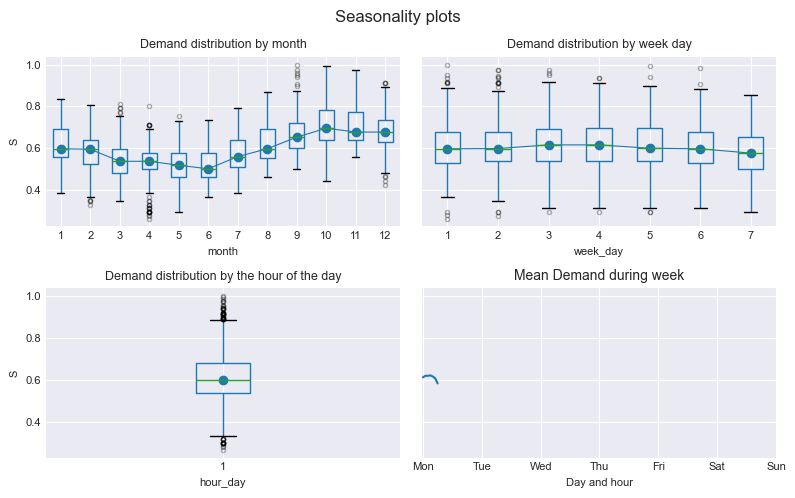

In [214]:
# Annual, weekly and daily seasonality
# ==============================================================================
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(8, 5), sharex=False, sharey=True)
axs = axs.ravel()

# Demand distribution by month
data['month'] = data.index.month
data.boxplot(column='S', by='month', ax=axs[0], flierprops={'markersize': 3, 'alpha': 0.3})
data.groupby('month')['S'].median().plot(style='o-', linewidth=0.8, ax=axs[0])
axs[0].set_ylabel('S')
axs[0].set_title('Demand distribution by month', fontsize=9)

# Demand distribution by week day
data['week_day'] = data.index.day_of_week + 1
data.boxplot(column='S', by='week_day', ax=axs[1], flierprops={'markersize': 3, 'alpha': 0.3})
data.groupby('week_day')['S'].median().plot(style='o-', linewidth=0.8, ax=axs[1])
axs[1].set_ylabel('S')
axs[1].set_title('Demand distribution by week day', fontsize=9)

# Demand distribution by the hour of the day
data['hour_day'] = data.index.hour + 1
data.boxplot(column='S', by='hour_day', ax=axs[2], flierprops={'markersize': 3, 'alpha': 0.3})
data.groupby('hour_day')['S'].median().plot(style='o-', linewidth=0.8, ax=axs[2])
axs[2].set_ylabel('S')
axs[2].set_title('Demand distribution by the hour of the day', fontsize=9)

# Demand distribution by week day and hour of the day
mean_day_hour = data.groupby(["week_day", "hour_day"])["S"].mean()
mean_day_hour.plot(ax=axs[3])
axs[3].set(
    title       = "Mean Demand during week",
    xticks      = [i * 24 for i in range(7)],
    xticklabels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel      = "Day and hour",
    ylabel      = "Number of Demand"
)
axs[3].title.set_size(10)

fig.suptitle("Seasonality plots", fontsize=12)
fig.tight_layout()


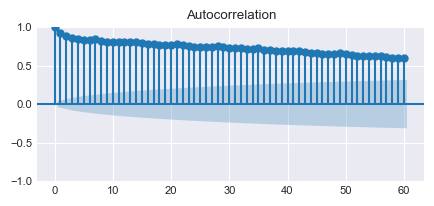

In [215]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_acf(data['S'], ax=ax, lags=60)
plt.show()


In [216]:
# Create baseline: value of the same hour of the previous day
# ==============================================================================
forecaster = ForecasterEquivalentDate(
                 offset    = pd.DateOffset(days=365),
                 n_offsets = 1
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=data.loc[:end_validation, 'S'])
forecaster


======================== 
ForecasterEquivalentDate 
======================== 
Offset: <DateOffset: days=365> 
Number of offsets: 1 
Aggregation function: mean 
Window size: 365 
Series name: S 
Training range: [Timestamp('2018-01-01 00:00:00'), Timestamp('2023-12-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: <Day> 
Creation date: 2025-12-18 15:15:49 
Last fit date: 2025-12-18 15:15:49 
Skforecast version: 0.19.1 
Python version: 3.12.0 
Forecaster id: None

In [217]:
# Backtesting
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 365,
        initial_train_size = len(data.loc[:end_validation]),
        refit              = False
)
metric, predictions = backtesting_forecaster(
                          forecaster = forecaster,
                          y          = data['S'],
                          cv         = cv,
                          metric     = 'mean_absolute_error'
                       )
metric


100%|██████████| 2/2 [00:00<00:00, 52.52it/s]


,mean_absolute_error
0,0.09


In [218]:
# Create forecaster
# ==============================================================================
window_features = RollingFeatures(stats=["mean"], window_sizes=365 * 3)
forecaster = ForecasterRecursive(
                 estimator       = LGBMRegressor(random_state=15926, verbose=-1),
                 lags            = 365,
                 window_features = window_features
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=data.loc[:end_validation, 'S'])
forecaster


=================== 
ForecasterRecursive 
=================== 
Estimator: LGBMRegressor 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252
 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270
 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288
 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306
 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324
 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342
 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360
 361 362 363 364 365] 
Window features: ['roll_mean_1095'] 
Window size: 1095 
Series name: S 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2018-01-01 00:00:00'), Timestamp('2023-12-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: <Day> 
Estimator parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample':
    1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-12-18 15:15:49 
Last fit date: 2025-12-18 15:15:50 
Skforecast version: 0.19.1 
Python version: 3.12.0 
Forecaster id: None

In [219]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster    = forecaster,
                          y             = data['S'],
                          cv            = cv,
                          metric        = 'mean_absolute_error',
                          verbose       = True, # Set to False to avoid printing
                      )


Information of folds
--------------------
Number of observations used for initial training: 2191
Number of observations used for backtesting: 366
    Number of folds: 2
    Number skipped folds: 0 
    Number of steps per fold: 365
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 1 observations.

Fold: 0
    Training:   2018-01-01 00:00:00 -- 2023-12-31 00:00:00  (n=2191)
    Validation: 2024-01-01 00:00:00 -- 2024-12-30 00:00:00  (n=365)
Fold: 1
    Training:   No training in this fold
    Validation: 2024-12-31 00:00:00 -- 2024-12-31 00:00:00  (n=1)



100%|██████████| 2/2 [00:00<00:00, 10.07it/s]


In [220]:
# Plot predictions vs real value
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['S'], name="test", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Real value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="Demand",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(orientation="h", yanchor="top", y=1.01, xanchor="left", x=0)
)
fig.show()

metric


,mean_absolute_error
0,0.10


## 2025

In [221]:
forecaster.fit(y=data['S'])
future_preds = forecaster.predict(steps=365)
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['S'], name="historical"))
fig.add_trace(go.Scatter(x=future_preds.index, y=future_preds, name="forecast 2025"))
fig.show()



# COMPARATIVO

In [222]:
# =============================================================================
# FORECASTING MODELS COMPARISON
# =============================================================================

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Backtesting configuration (same for all models)
cv = TimeSeriesFold(
    steps=365,
    initial_train_size=len(data.loc[:end_validation]),
    refit=False
)

window_features = RollingFeatures(
    stats=["mean"],
    window_sizes=365 * 3
)

models = {
    "Baseline_7days": ForecasterEquivalentDate(
        offset=pd.DateOffset(days=365),
        n_offsets=1
    ),

    "Ridge": ForecasterRecursive(
        estimator=Ridge(alpha=1.0),
        lags=365,
        window_features=window_features
    ),

    "RandomForest": ForecasterRecursive(
        estimator=RandomForestRegressor(
            n_estimators=300,
            max_depth=12,
            random_state=15926,
            n_jobs=-1
        ),
        lags=365,
        window_features=window_features
    ),

    "LightGBM": ForecasterRecursive(
        estimator=LGBMRegressor(
            n_estimators=500,
            learning_rate=0.05,
            random_state=15926,
            verbose=-1
        ),
        lags=365,
        window_features=window_features
    ),

    "XGBoost": ForecasterRecursive(
        estimator=XGBRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=15926,
            objective="reg:squarederror",
            n_jobs=-1
        ),
        lags=365,
        window_features=window_features
    )
}


results = {}
predictions_dict = {}

# =============================================================================
# TRAINING + BACKTESTING
# =============================================================================

for name, forecaster in models.items():

    print(f"\nTraining model: {name}")

    forecaster.fit(y=data.loc[:end_validation, 'S'])

    metric, predictions = backtesting_forecaster(
        forecaster=forecaster,
        y=data['S'],
        cv=cv,
        metric='mean_absolute_error',
        verbose=False
    )

    results[name] = metric.iloc[0, 0]
    predictions_dict[name] = predictions


# =============================================================================
# RESULTS TABLE
# =============================================================================

results_df = pd.DataFrame.from_dict(
    results, orient='index', columns=['MAE']
).sort_values('MAE')

print("\nModel comparison (lower MAE is better):")
display(results_df)



Training model: Baseline_7days


100%|██████████| 2/2 [00:00<00:00, 55.71it/s]



Training model: Ridge


100%|██████████| 2/2 [00:00<00:00, 62.55it/s]



Training model: RandomForest


100%|██████████| 2/2 [00:00<00:00, 281.13it/s]



Training model: LightGBM


100%|██████████| 2/2 [00:00<00:00,  9.32it/s]



Training model: XGBoost


100%|██████████| 2/2 [00:00<00:00, 1000.67it/s]



Model comparison (lower MAE is better):


,MAE
XGBoost,0.08
LightGBM,0.09
Baseline_7days,0.09
RandomForest,0.09
Ridge,0.18


In [223]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=data_test.index,
        y=data_test['S'],
        name="Observed",
        mode="lines"
    )
)

for name, preds in predictions_dict.items():
    fig.add_trace(
        go.Scatter(
            x=preds.index,
            y=preds['pred'],
            name=name,
            mode="lines",
            opacity=0.7
        )
    )

fig.update_layout(
    title="Model comparison – Test period forecast",
    xaxis_title="Date",
    yaxis_title="Demand",
    width=900,
    height=450
)

fig.show()


In [224]:
best_model_name = results_df.index[0]
best_forecaster = models[best_model_name]

best_forecaster.fit(y=data['S'])
forecast_2025 = best_forecaster.predict(steps=365)

fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['S'], name="Historical"))
fig.add_trace(go.Scatter(x=forecast_2025.index, y=forecast_2025, name="Forecast 2025"))
fig.update_layout(
    title=f"Final forecast for 2025 ({best_model_name})",
    width=900,
    height=450
)
fig.show()


### DL